# Efficiency

For each length, we can compute the actual number of LLM calls we need to make if we were not condensing.
This number will be $N \geq \log(2m/\delta)/(2\varepsilon^2)$.
But we will check the actual llm calls, which is the samples (the unique samples).
We will check for both p=0.95 and p=1.
We are using $\delta=0.1$ and $\varepsilon=0.1$ here.
We'll do it for all the datasets.

1. per-step samples on average
2. total samples per example

In [1]:
import os
import json
import math
from collections import OrderedDict, defaultdict
from tqdm.auto import tqdm

delta = 0.1
epsilon = 0.1

def get_N(m, delta, epsilon):
    return math.ceil(math.log(2*m/delta)/(2*epsilon**2))

def flatten(l):
    return [item for sublist in l for item in sublist]

print(math.ceil(get_N(10, delta, epsilon)))

ROOT_DIR = '..'

dataset_names_long = OrderedDict([
    ('synthchain_vanilla3_no_repeat_5_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', r'ClaimTrees-5'),
    ('synthchain_vanilla3_no_repeat_10_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', r'ClaimTrees-10'),
    ('synthchain_vanilla3_no_repeat_20_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', r'ClaimTrees-20'),
    ('synthchain_vanilla3_no_repeat_30_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', r'ClaimTrees-30'),
    ('synthchain_vanilla3_no_repeat_50_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', r'ClaimTrees-50'),
    ('recipe_graph3.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot3', r'CaptainCookRecipes'),
    ('prmbench.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot2', r'PRMBench'),
    ('deltabench_sections.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot3', r'DeltaBench')
])

actual_counts_dict = {}
theoretical_counts_dict = {}

for dataset_name in tqdm(dataset_names_long):
    dataset_dir = os.path.join(ROOT_DIR, 
                        'results/stability_rate', dataset_name)
    filenames = os.listdir(dataset_dir)

    all_actual_counts = []
    all_theoretical_counts = []
    for filename in filenames:
        data_path = os.path.join(dataset_dir, filename)

        with open(data_path, 'rt') as input_file:
            data = json.load(input_file)

        actual_counts = []
        theoretical_counts = []
        for i in range(len(data['stab_rate_results'])):
            actual_counts.append(len(data['stab_rate_results'][i]['stab_rate_results']['samples']))
            theoretical_counts.append(get_N(len(data['stab_rate_results']), delta, epsilon))
        sum(actual_counts), sum(theoretical_counts)
        all_actual_counts.append(actual_counts)
        all_theoretical_counts.append(theoretical_counts)

    # sum(flatten(all_actual_counts)), sum(flatten(all_theoretical_counts))
    actual_counts_dict[dataset_name] = all_actual_counts
    theoretical_counts_dict[dataset_name] = all_theoretical_counts

265


  0%|          | 0/8 [00:00<?, ?it/s]

In [2]:
actual_counts_dict.keys()

dict_keys(['synthchain_vanilla3_no_repeat_5_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', 'synthchain_vanilla3_no_repeat_10_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', 'synthchain_vanilla3_no_repeat_20_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', 'synthchain_vanilla3_no_repeat_30_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', 'synthchain_vanilla3_no_repeat_50_2.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot', 'recipe_graph3.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot3', 'prmbench.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot2', 'deltabench_sections.val.gpt-4o-mini.cert_granular_temp0_nonexact.p0.95.no_cot3'])

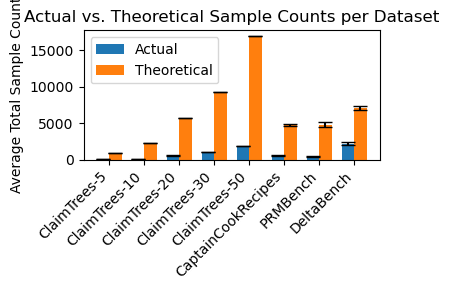

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# -----------------------------------------------------------------------------
# Assumes you already have:
#   actual_counts_dict: Dict[str, List[List[int]]]
#   theoretical_counts_dict: Dict[str, List[List[int]]]
#   dataset_names_long: OrderedDict[str, str]  # mapping key→label
# -----------------------------------------------------------------------------

datasets = list(dataset_names_long.keys())
labels   = [dataset_names_long[k] for k in datasets]

actual_means, actual_errs = [], []
theo_means,   theo_errs   = [], []
B = 1000   # number of bootstrap resamples

for ds in datasets:
    # 1) sum each run
    a_runs = actual_counts_dict[ds]
    t_runs = theoretical_counts_dict[ds]
    a_sums = [sum(run) for run in a_runs]
    t_sums = [sum(run) for run in t_runs]

    # 2) compute mean
    actual_means.append(np.mean(a_sums))
    theo_means.append(np.mean(t_sums))

    # 2') bootstrap‐estimate standard error of the mean
    a_boot = [np.mean(random.choices(a_sums, k=len(a_sums))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_sums, k=len(t_sums))) for _ in range(B)]
    actual_errs.append(np.std(a_boot, ddof=1))
    theo_errs.append(np.std(t_boot, ddof=1))

# 3) grouped bar plot
x     = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(4, 3))
plt.bar(x - width/2, actual_means, width, yerr=actual_errs, capsize=5, label='Actual')
plt.bar(x + width/2,   theo_means,   width, yerr=theo_errs,   capsize=5, label='Theoretical')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Average Total Sample Count")
plt.title("Actual vs. Theoretical Sample Counts per Dataset")
plt.legend()
plt.tight_layout()
plt.show()


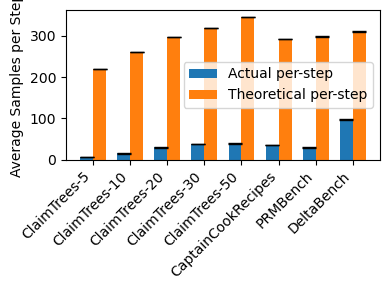

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

def flatten(lists):
    return [item for sublist in lists for item in sublist]

# If you have:
#   actual_counts_dict: Dict[str, List[List[int]]]
#   theoretical_counts_dict: Dict[str, List[List[int]]]
#   dataset_names_long: OrderedDict[str, str]  # mapping key → label
datasets = list(dataset_names_long.keys())
labels   = [dataset_names_long[k] for k in datasets]

B = 1000  # bootstrap resamples

actual_means, actual_errs = [], []
theo_means,   theo_errs   = [], []

for ds in datasets:
    a_flat = flatten(actual_counts_dict[ds])
    t_flat = flatten(theoretical_counts_dict[ds])

    # true means
    mu_a = np.mean(a_flat)
    mu_t = np.mean(t_flat)
    actual_means.append(mu_a)
    theo_means.append(mu_t)

    # bootstrap‐SE for the mean
    a_boot = [np.mean(random.choices(a_flat, k=len(a_flat))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_flat, k=len(t_flat))) for _ in range(B)]
    actual_errs.append(np.std(a_boot, ddof=1))
    theo_errs.append(np.std(t_boot, ddof=1))

# --- draw grouped bar plot ---
x     = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(4, 3))
plt.bar(x - width/2, actual_means, width, yerr=actual_errs, capsize=5, label='Actual per-step')
plt.bar(x + width/2,   theo_means,   width, yerr=theo_errs,   capsize=5, label='Theoretical per-step')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Average Samples per Step")
# plt.title("Number of Samples per Step")
plt.legend()
plt.tight_layout()
plt.show()


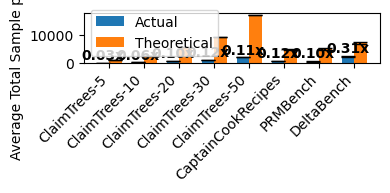

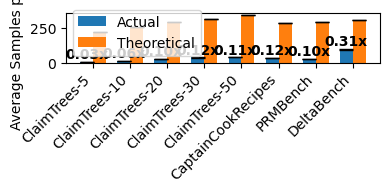

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
# ── FIGURE: TREND LINES WITH ±1 STD SHADE ───────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt

# Option 1: using rcParams directly
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size']   = 10

def flatten(lists):
    return [item for sublist in lists for item in sublist]

# -----------------------------------------------------------------------------
# Assumes you already have:
#   actual_counts_dict: Dict[str, List[List[int]]]
#   theoretical_counts_dict: Dict[str, List[List[int]]]
#   dataset_names_long: OrderedDict[str, str]  # mapping key → label
# -----------------------------------------------------------------------------

# Bootstrap parameters
B = 1000  

# Prepare dataset keys & labels
datasets = list(dataset_names_long.keys())
labels   = [dataset_names_long[k] for k in datasets]
x        = np.arange(len(datasets))
width    = 0.35

# 1) TOTAL COUNTS
actual_totals = []
theo_totals   = []
actual_tot_err = []
theo_tot_err   = []

for ds in datasets:
    a_runs = actual_counts_dict[ds]
    t_runs = theoretical_counts_dict[ds]
    
    # sum per-run
    a_sums = [sum(run) for run in a_runs]
    t_sums = [sum(run) for run in t_runs]
    
    # true means
    mu_a = np.mean(a_sums)
    mu_t = np.mean(t_sums)
    actual_totals.append(mu_a)
    theo_totals.append(mu_t)
    
    # bootstrap‐SE
    a_boot = [np.mean(random.choices(a_sums, k=len(a_sums))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_sums, k=len(t_sums))) for _ in range(B)]
    actual_tot_err.append(np.std(a_boot, ddof=1))
    theo_tot_err.append(np.std(t_boot, ddof=1))

# Plot TOTAL grouped bar with ratio annotation
fig, ax = plt.subplots(figsize=(4, 2))
bars_a  = ax.bar(x - width/2, actual_totals, width, yerr=actual_tot_err, capsize=5, label='Actual')
bars_t  = ax.bar(x + width/2, theo_totals,   width, yerr=theo_tot_err,   capsize=5, label='Theoretical')

for i, bar in enumerate(bars_a):
    h     = bar.get_height()
    ratio = (actual_totals[i] / theo_totals[i]) if theo_totals[i] != 0 else float('nan')
    y     = h + actual_tot_err[i] * 1.5
    ax.text(
        bar.get_x() + bar.get_width()/2,
        y,
        f"{ratio:.2f}x",
        ha='center', va='bottom', fontweight='bold'
    )

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel("Average Total Sample per Example")
# ax.set_title("Actual vs. Theoretical Total Sample Counts by Dataset")
ax.legend()
plt.tight_layout()
plt.show()

# 2) PER‐STEP COUNTS
actual_step     = []
theo_step       = []
actual_step_err = []
theo_step_err   = []

for ds in datasets:
    a_flat = flatten(actual_counts_dict[ds])
    t_flat = flatten(theoretical_counts_dict[ds])
    
    # true means
    mu_a = np.mean(a_flat)
    mu_t = np.mean(t_flat)
    actual_step.append(mu_a)
    theo_step.append(mu_t)
    
    # bootstrap‐SE
    a_boot = [np.mean(random.choices(a_flat, k=len(a_flat))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_flat, k=len(t_flat))) for _ in range(B)]
    actual_step_err.append(np.std(a_boot, ddof=1))
    theo_step_err.append(np.std(t_boot, ddof=1))

# Plot PER‐STEP grouped bar with ratio annotation
fig, ax = plt.subplots(figsize=(4, 2))
bars_a2 = ax.bar(x - width/2, actual_step,   width, yerr=actual_step_err, capsize=5, label='Actual')
bars_t2 = ax.bar(x + width/2, theo_step,     width, yerr=theo_step_err,   capsize=5, label='Theoretical')

for i, bar in enumerate(bars_a2):
    h     = bar.get_height()
    ratio = (actual_step[i] / theo_step[i]) if theo_step[i] != 0 else float('nan')
    y     = h + actual_step_err[i] * 1.5
    ax.text(
        bar.get_x() + bar.get_width()/2,
        y,
        f"{ratio:.2f}x",
        ha='center', va='bottom', fontweight='bold'
    )

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel("Average Samples per Step")
# ax.set_title("Actual vs. Theoretical Samples per Step by Dataset")
ax.legend()
plt.tight_layout()
plt.show()


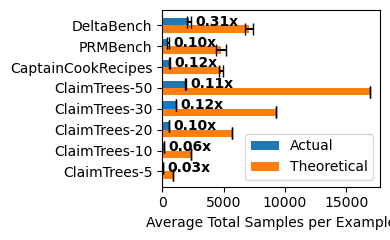

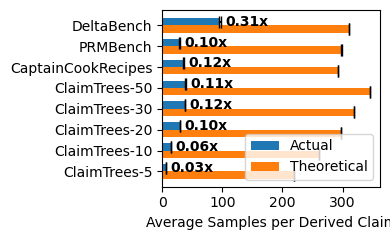

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

def flatten(lists):
    return [item for sublist in lists for item in sublist]

# ── assume you already have these dicts ──
# actual_counts_dict, theoretical_counts_dict, dataset_names_long

B = 1000
datasets = list(dataset_names_long.keys())
labels   = [dataset_names_long[k] for k in datasets]

# Precompute stats
actual_totals, theo_totals = [], []
actual_tot_err, theo_tot_err = [], []
actual_step,   theo_step = [], []
actual_step_err, theo_step_err = [], []

for ds in datasets:
    # TOTAL
    a_sums = [sum(r) for r in actual_counts_dict[ds]]
    t_sums = [sum(r) for r in theoretical_counts_dict[ds]]
    actual_totals.append(np.mean(a_sums));  theo_totals.append(np.mean(t_sums))
    a_boot = [np.mean(random.choices(a_sums, k=len(a_sums))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_sums, k=len(t_sums))) for _ in range(B)]
    actual_tot_err.append(np.std(a_boot, ddof=1));  theo_tot_err.append(np.std(t_boot, ddof=1))

    # PER‐STEP
    a_flat = flatten(actual_counts_dict[ds])
    t_flat = flatten(theoretical_counts_dict[ds])
    actual_step.append(np.mean(a_flat));  theo_step.append(np.mean(t_flat))
    a_boot = [np.mean(random.choices(a_flat, k=len(a_flat))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_flat, k=len(t_flat))) for _ in range(B)]
    actual_step_err.append(np.std(a_boot, ddof=1));  theo_step_err.append(np.std(t_boot, ddof=1))


# Common y positions & bar thickness
y      = np.arange(len(datasets))
height = 0.35

# ── 1) TOTAL COUNTS ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(4, 2.5))

bars_a = ax.barh(y + height/2,
                 actual_totals,
                 height,
                 xerr=actual_tot_err,
                 capsize=4,
                 label='Actual')
bars_t = ax.barh(y - height/2,
                 theo_totals,
                 height,
                 xerr=theo_tot_err,
                 capsize=4,
                 label='Theoretical')

# compute a small constant margin = 2% of the x-axis range
x_min, x_max = ax.get_xlim()
margin = (x_max - x_min) * 0.02

# annotate ratio just to the right of each actual bar
for i, bar in enumerate(bars_a):
    x_end = bar.get_width()
    ratio = actual_totals[i] / theo_totals[i] if theo_totals[i] else np.nan
    ax.text(x_end + actual_tot_err[i] + margin,
            bar.get_y() + bar.get_height()/2,
            f"{ratio:.2f}x",
            va='center',
            ha='left',
            fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel("Average Total Samples per Example")
# ax.set_title("Total Sample Counts\nActual vs. Theoretical")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, 'metrics', 'figures', 'per_example_total_samples.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


# ── 2) PER‐STEP COUNTS ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(4, 2.5))

bars_a2 = ax.barh(y + height/2,
                  actual_step,
                  height,
                  xerr=actual_step_err,
                  capsize=4,
                  label='Actual')
bars_t2 = ax.barh(y - height/2,
                  theo_step,
                  height,
                  xerr=theo_step_err,
                  capsize=4,
                  label='Theoretical')

# update margin in case the scale changed
x_min, x_max = ax.get_xlim()
margin = (x_max - x_min) * 0.02

for i, bar in enumerate(bars_a2):
    x_end = bar.get_width()
    ratio = actual_step[i] / theo_step[i] if theo_step[i] else np.nan
    ax.text(x_end + actual_step_err[i] + margin,
            bar.get_y() + bar.get_height()/2,
            f"{ratio:.2f}x",
            va='center',
            ha='left',
            fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel("Average Samples per Derived Claim")
# ax.set_title("Per-Step Sample Counts\nActual vs. Theoretical")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, 'metrics', 'figures', 'per_step_samples.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


/tmp/ipykernel_99435/1009938207.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


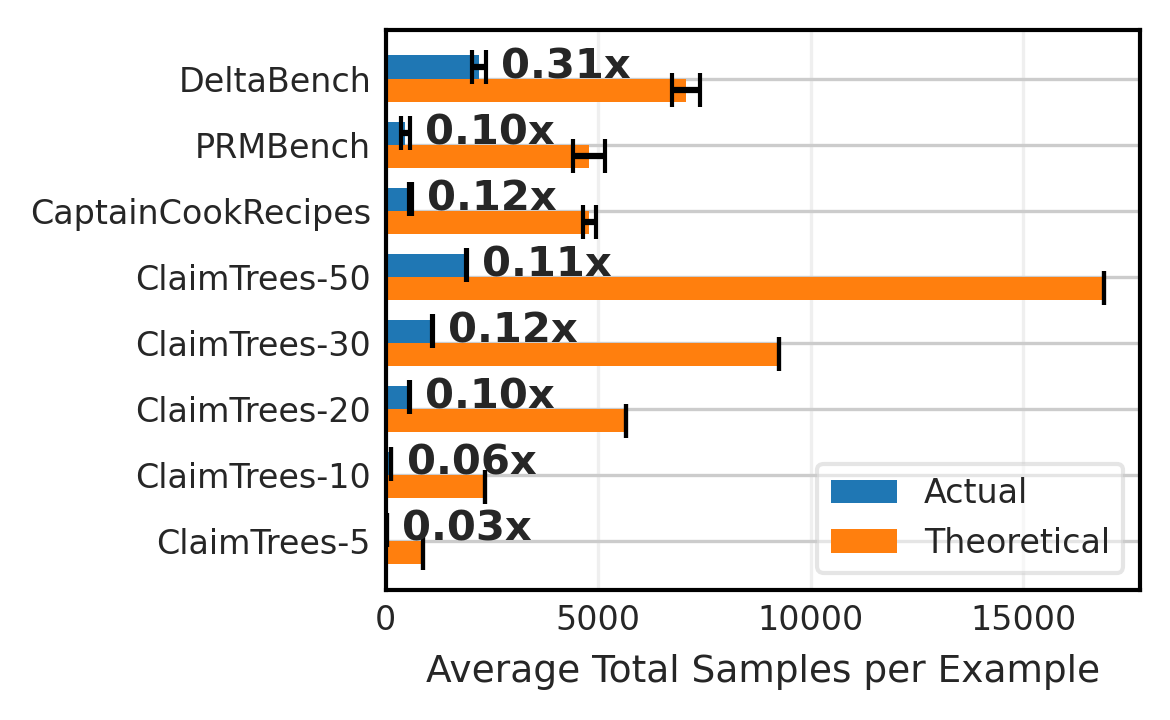

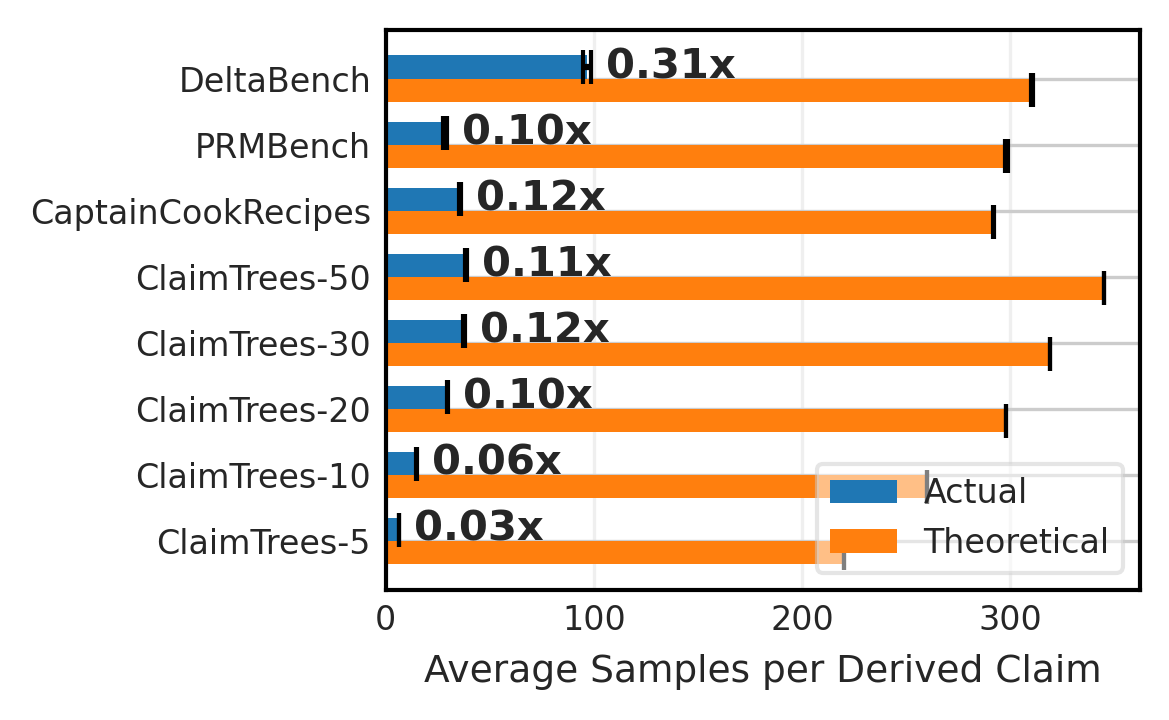

In [6]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# ——— Style setup —————————————————————————————————————————————
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "figure.dpi": 300,
    "axes.edgecolor": "black",
})
# ——————————————————————————————————————————————————————————————————————

def flatten(lists):
    return [item for sublist in lists for item in sublist]

# ── assume you already have these dicts ──
# actual_counts_dict, theoretical_counts_dict, dataset_names_long

B = 1000
datasets = list(dataset_names_long.keys())
labels   = [dataset_names_long[k] for k in datasets]

# Precompute stats
actual_totals, theo_totals = [], []
actual_tot_err, theo_tot_err = [], []
actual_step,   theo_step = [], []
actual_step_err, theo_step_err = [], []

for ds in datasets:
    # TOTAL
    a_sums = [sum(r) for r in actual_counts_dict[ds]]
    t_sums = [sum(r) for r in theoretical_counts_dict[ds]]
    actual_totals.append(np.mean(a_sums));  theo_totals.append(np.mean(t_sums))
    a_boot = [np.mean(random.choices(a_sums, k=len(a_sums))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_sums, k=len(t_sums))) for _ in range(B)]
    actual_tot_err.append(np.std(a_boot, ddof=1));  theo_tot_err.append(np.std(t_boot, ddof=1))

    # PER‐STEP
    a_flat = flatten(actual_counts_dict[ds])
    t_flat = flatten(theoretical_counts_dict[ds])
    actual_step.append(np.mean(a_flat));  theo_step.append(np.mean(t_flat))
    a_boot = [np.mean(random.choices(a_flat, k=len(a_flat))) for _ in range(B)]
    t_boot = [np.mean(random.choices(t_flat, k=len(t_flat))) for _ in range(B)]
    actual_step_err.append(np.std(a_boot, ddof=1));  theo_step_err.append(np.std(t_boot, ddof=1))


# Common y positions & bar thickness
y      = np.arange(len(datasets))
height = 0.35

# ── 1) TOTAL COUNTS ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(4, 2.5))

bars_a = ax.barh(y + height/2,
                 actual_totals,
                 height,
                 xerr=actual_tot_err,
                 capsize=4,
                 label='Actual')
bars_t = ax.barh(y - height/2,
                 theo_totals,
                 height,
                 xerr=theo_tot_err,
                 capsize=4,
                 label='Theoretical')

# lightly grid the x-axis
ax.grid(axis='x', alpha=0.3)

# compute a small constant margin = 2% of the x-axis range
x_min, x_max = ax.get_xlim()
margin = (x_max - x_min) * 0.02

# annotate ratio just to the right of each actual bar
for i, bar in enumerate(bars_a):
    x_end = bar.get_width()
    ratio = actual_totals[i] / theo_totals[i] if theo_totals[i] else np.nan
    ax.text(x_end + actual_tot_err[i] + margin,
            bar.get_y() + bar.get_height()/2,
            f"{ratio:.2f}x",
            va='center',
            ha='left',
            fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel("Average Total Samples per Example")
ax.legend(loc='lower right',
          frameon=True,       # make sure the frame is drawn
          framealpha=0.5,     # 50% opacity
          facecolor='white')  # white background

plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, 'metrics', 'figures', 'per_example_total_samples.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()


# ── 2) PER‐STEP COUNTS ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(4, 2.5))

bars_a2 = ax.barh(y + height/2,
                  actual_step,
                  height,
                  xerr=actual_step_err,
                  capsize=4,
                  label='Actual')
bars_t2 = ax.barh(y - height/2,
                  theo_step,
                  height,
                  xerr=theo_step_err,
                  capsize=4,
                  label='Theoretical')

ax.grid(axis='x', alpha=0.3)

x_min, x_max = ax.get_xlim()
margin = (x_max - x_min) * 0.02

for i, bar in enumerate(bars_a2):
    x_end = bar.get_width()
    ratio = actual_step[i] / theo_step[i] if theo_step[i] else np.nan
    ax.text(x_end + actual_step_err[i] + margin,
            bar.get_y() + bar.get_height()/2,
            f"{ratio:.2f}x",
            va='center',
            ha='left',
            fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel("Average Samples per Derived Claim")
ax.legend(loc='lower right',
          frameon=True,       # make sure the frame is drawn
          framealpha=0.5,     # 50% opacity
          facecolor='white')  # white background

plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, 'metrics', 'figures', 'per_step_samples.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()


In [16]:
fi = 0
filename = filenames[fi]

data_path = os.path.join(dataset_dir, filename)

with open(data_path, 'rt') as input_file:
    data = json.load(input_file)
    
actual_counts = []
theoretical_counts = []
for i in range(len(data['stab_rate_results'])):
    actual_counts.append(len(data['stab_rate_results'][i]['stab_rate_results']['samples']))
    theoretical_counts.append(get_N(len(data['stab_rate_results']), delta, epsilon))
sum(actual_counts), sum(theoretical_counts)

(1016, 9251)

In [1]:
import json

data_path = '/shared_data0/weiqiuy/veritas/results/stability_rate/synthchain_vanilla3_no_repeat_5_2/0.json'

with open(data_path, 'rt') as input_file:
    data = json.load(input_file)

In [3]:
data.keys()

dict_keys(['stability_rate', 'stability_rates', 'inputs', 'children', 'parents', 'stab_rate_results'])

In [9]:
samples = data['stab_rate_results'][0]['stab_rate_results']['samples']

In [10]:
len(samples)

104

In [14]:
all_counts = []
for i in range(len(data['stab_rate_results'])):
    all_counts.append(len(data['stab_rate_results'][i]['stab_rate_results']['samples']))

In [15]:
sum(all_counts)

1064

In [16]:
all_counts, len(all_counts)

([104,
  89,
  80,
  73,
  60,
  52,
  46,
  43,
  40,
  37,
  32,
  31,
  29,
  30,
  26,
  26,
  23,
  22,
  22,
  22,
  22,
  20,
  20,
  20,
  20,
  19,
  19,
  19,
  18],
 29)

In [21]:
import json

data_path = '/shared_data0/weiqiuy/veritas/results/stability_rate/synthchain_vanilla_30.val.gpt-4o-mini.cert_granular_temp0_nonexact.p1.better_prompt1/1.json'

with open(data_path, 'rt') as input_file:
    data = json.load(input_file)

In [22]:
all_counts = []
for i in range(len(data['stab_rate_results'])):
    all_counts.append(len(data['stab_rate_results'][i]['stab_rate_results']['samples']))
sum(all_counts)

29

In [23]:
data['stability_rates']

[1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]